# Useful imports

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pylab
import scipy.stats
%matplotlib inline
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

# CUSUM

## Offline

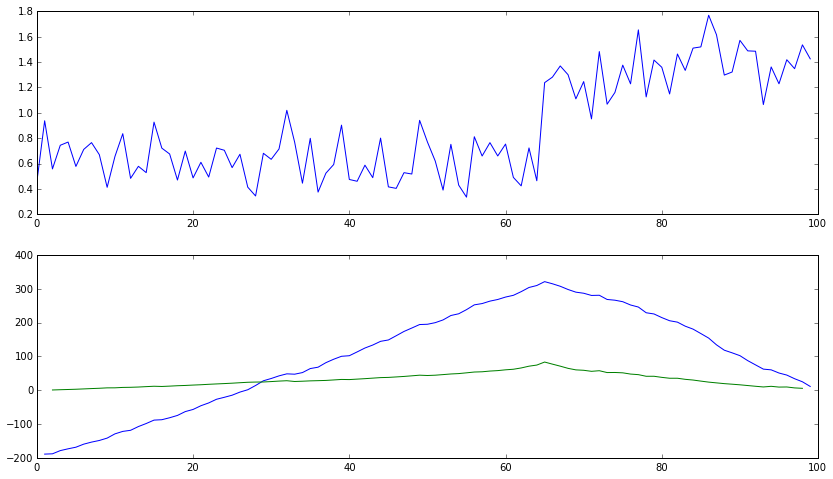

In [2]:
data = pickle.load(open('cusum.pick','rb'))

data = data[1]

signal = data['signal']
mu0 = data['mu0']
mu1 = data['mu1']
sigma0 = data['sigma0']
sigma1 = data['sigma1']

n = len(signal)

def likelihood(mu, sigma, x):
    x = np.atleast_1d(x)
    xl = -np.log(sigma) - 1. / 2 * np.log(2. * np.pi) - (x - mu)**2 / (2 * sigma**2)
    return np.sum(xl)

def vraissemblanceParamsConnus (signal, mu0, mu1, muTilde, sigma0, sigma1, sigmaTilde):
    n = len(signal)
    vraissemblance = np.zeros((n-1,))

    for t0 in range(1, n):
        l1 = likelihood(mu1, sigma1, signal[t0:])
        l0 = likelihood(mu0, sigma0, signal[:t0])
        l00 = likelihood(muTilde, sigmaTilde, signal)

        vraissemblance[t0 - 1] = l0 + l1 - l00
    
    return vraissemblance


def vraissemblanceParamsInconnus (signal):
    n = len(signal)
    vraissemblance = np.zeros((n-3,))

    for t0 in range(2, n-1):

        mu0 = np.mean(signal[:t0])
        mu1 = np.mean(signal[t0:])
        muTilde = np.mean(signal)

        sigma0 = np.std(signal[:t0])
        sigma1 = np.std(signal[t0:])
        sigmaTilde = np.std(signal)
        
        l1 = likelihood(mu1, sigma1, signal[t0:])
        l0 = likelihood(mu0, sigma0, signal[:t0])
        l00 = likelihood(muTilde, sigmaTilde, signal)

        vraissemblance[t0 - 2] = l0 + l1 - l00
    
    return vraissemblance

plt.subplot(2,1,1)
plt.plot(signal)
plt.subplot(2,1,2)
plt.plot(range(1,n), vraissemblanceParamsConnus(signal, mu0, mu1, mu0, sigma0, sigma1, sigma0))
plt.plot(range(2, n-1), vraissemblanceParamsInconnus(signal))

## Online

Rupture at 64 found at 68


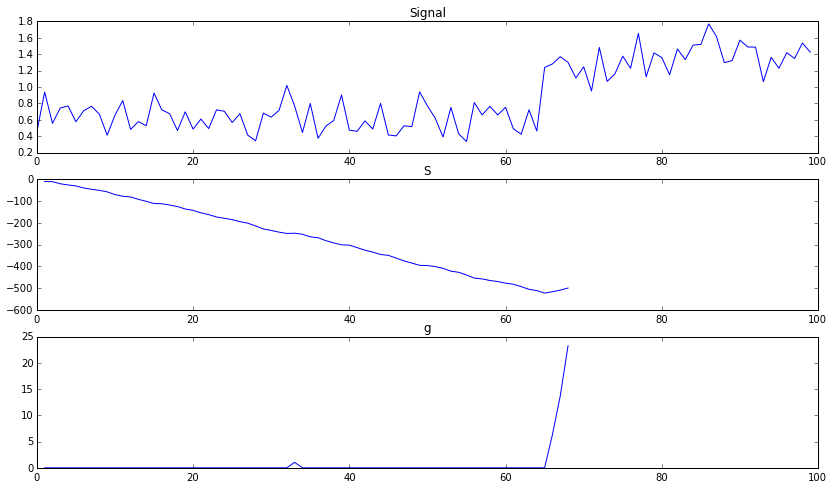

Rupture at 65 found at 68


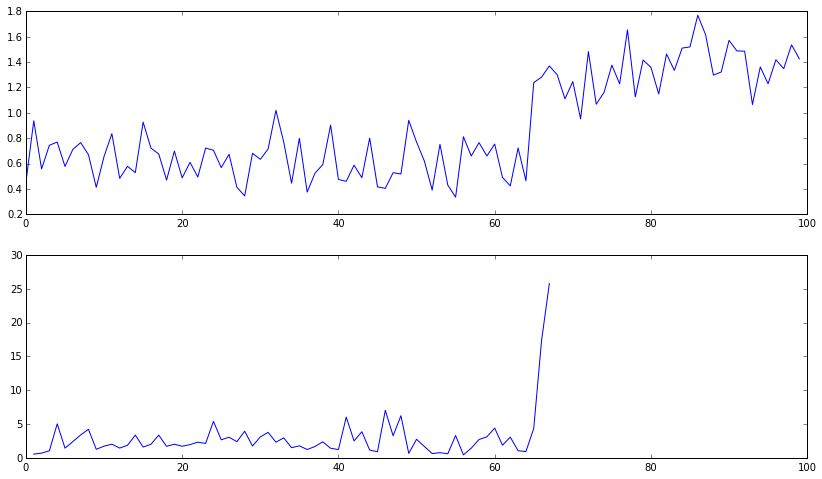

In [3]:
data = pickle.load(open('cusum.pick','rb'))

data = data[1]

signal = data['signal']
mu0 = data['mu0']
mu1 = data['mu1']
sigma0 = data['sigma0']
sigma1 = data['sigma1']

def likelihood(mu, sigma, x):
    x = np.atleast_1d(x)
    xl = -np.log(sigma) - 1. / 2 * np.log(2. * np.pi) - (x - mu)**2 / (2 * sigma**2)
    return np.sum(xl)

def vraissemblanceParamsConnus (signal, mu0, mu1, sigma0, sigma1):

    l0 = likelihood(mu0, sigma0, signal)
    l1 = likelihood(mu1, sigma1, signal)

    return l1 - l0

def vraissemblanceParamsInconnus (signal, mu0, sigma0):

    k = len(signal) - 1
    Sjs = np.zeros((k,))

    for j in range(k):

        mu1 = np.mean(signal[j:])
        sigma1 = np.std(signal[j:])
        
        l0 = likelihood(mu0, sigma0, signal[j:])
        l1 = likelihood(mu1, sigma1, signal[j:])

        Sjs[j] = l1 - l0
    
    return Sjs

def ruptureOnlineParamsConnus (signal, mu0, mu1, sigma0, sigma1):

    n = len(signal)
    S = np.zeros((n-1,))
    g = np.zeros((n-1,))
    h = 20

    for i in range(1,n):
        Sk = vraissemblanceParamsConnus(signal[:i], mu0, mu1, sigma0, sigma1)
        S[i-1] = Sk;
        mk = np.min(S[:i])
        gk = Sk - mk
        g[i-1] = gk

        if (gk > h):
            t0 = np.argmin(S[:i])
            break

    ta = i
    print("Rupture at " + str(t0) + " found at " + str(ta))

    plt.subplot(3,1,1)
    plt.plot(signal)
    plt.xlim([0,n])
    plt.title('Signal')
    plt.subplot(3,1,2)
    plt.plot(range(1,ta+1), S[:ta])
    plt.xlim([0,n])
    plt.title('S')
    plt.subplot(3,1,3)
    plt.plot(range(1,ta+1), g[:ta])
    plt.xlim([0,n])
    plt.title('g')
    plt.show()

def ruptureOnlineParamsInconnus (signal, mu0, sigma0):

    n = len(signal)
    g = np.zeros((n-2,))
    h = 20

    for i in range(2,n):
        Sjs = vraissemblanceParamsInconnus(signal[:i], mu0, sigma0)
        gk = np.max(Sjs);
        g[i-2] = gk;

        if (gk > h):
            t0 = np.argmax(Sjs)
            break

    ta = i
    print("Rupture at " + str(t0) + " found at " + str(ta))

    plt.subplot(2,1,1)
    plt.plot(signal)
    plt.xlim([0,n])
    plt.subplot(2,1,2)
    plt.plot(range(1,ta), g[:ta-1])
    plt.xlim([0,n])
    plt.show()

ruptureOnlineParamsConnus (signal, mu0, mu1, sigma0, sigma1)
ruptureOnlineParamsInconnus (signal, mu0, sigma0)

# Filtered derivative
## Seuil fixé

In [4]:
C = 0.5

In [5]:
data = pickle.load(open('cusum.pick','rb'))

data = data[1]

signal = data['signal']
mu0 = data['mu0']
mu1 = data['mu1']
sigma0 = data['sigma0']
sigma1 = data['sigma1']

In [6]:
def calculDifference(A1, A2, signal):
    n = len(signal)
    
    D = np.zeros((n,))
    D[:] = np.NAN

    # for i, k in enumerate(range(A1, n - A2 + 1)):
    for k in range(A1, n - A2 + 1):
        D[k] = np.abs(np.mean(signal[k:k+A2]) - np.mean(signal[k-A1:k]))
    
    return D

D = calculDifference(5, 5, signal)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app


<Container object of 3 artists>

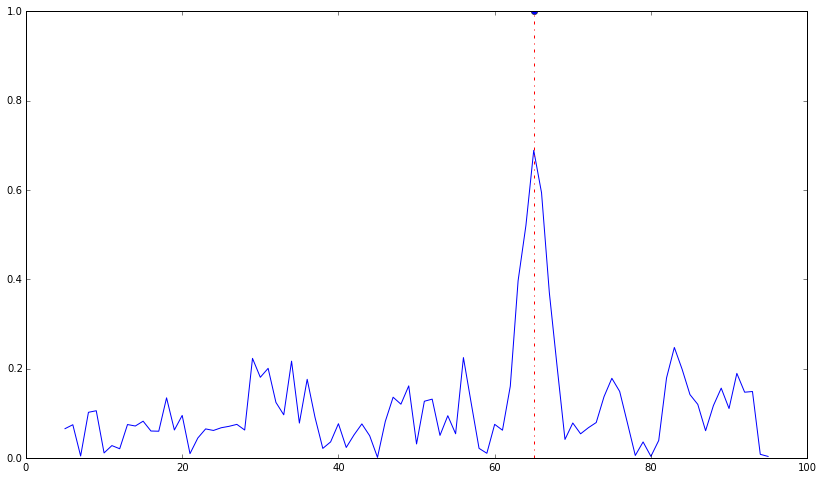

In [7]:
def detectionRupture(D, C):
    zonesRupture = np.greater(D, C)
    pointsRupture = []
    
    ruptStart = 0;
    for i in range(1, len(zonesRupture)):
        if zonesRupture[i] == 1 and zonesRupture[i-1] == 0:
            ruptStart = i
        elif zonesRupture[i] == 0 and zonesRupture[i-1] == 1:
            pointsRupture.append(ruptStart + np.argmax(D[ruptStart:i+1]))

    return (zonesRupture, pointsRupture)

(zonesRupture, pointsRupture) = detectionRupture(D, C)

plt.plot(D)
plt.stem(pointsRupture, np.ones((len(pointsRupture),)), '-.r')

## Recherche seuil C

In [8]:
def calculMsRandperm(A1, A2, signal, n):
    Ms = np.zeros((n,))

    for i in range(n):
        signalPerm = np.random.permutation(signal)
        Ms[i] = np.nanmax(calculDifference(A1, A2, signalPerm))

    return Ms

Ms = calculMsRandperm(5, 5, signal, 1000)

In [9]:
def findC(Ms, p):
    return scipy.stats.norm.ppf(1 - p,loc=np.mean(Ms), scale=np.std(Ms))

In [13]:
C = findC(Ms, 0.1)

D = calculDifference(10, 10, signal)
(zonesRupture, pointsRupture) = detectionRupture(D, C)
C

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app


0.76301602488289277